# SSQA - Tutorials

In [1]:
import sys, os, re, random, warnings, subprocess, torch
sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

Here we recall the full pipeline for Pattern Matching

## 1 - Data Collection



In [2]:
from config import PFAM_DATA
from data import *

Define the dataset `DATASET` and the file `filename` where all **aligned** sequences are. The data file `data.pt` will be stored in `PFAM_DATA/DATASET` folder 

In [3]:
DATASET = "PF00397"
filename = "full.fasta"
folder = f"{PFAM_DATA}/{DATASET}"

We start with the two first steps :
- Clustering and splitting the clusters between training and testing set with MMSEQS
- Build HMMer profile with HHsuite

In [9]:
build_protein_df(f"{folder}", filename)

# We build clusters with MMSEQS
subprocess.run(
    f'mmseqs easy-cluster "{folder}/unaligned.fasta" "{folder}/tmp/clusters.tsv" "{folder}/tmp" --min-seq-id 0.7',
    shell=True)

# We compute cluster weights
cluster_weights(folder)

# We split between training and validation set (useful for training RBM)
split_train_val_set(folder)

# We compute profiles
subprocess.run(f'hhmake -i {folder}/aligned.fasta -M 100', shell=True)
build_profiles(folder)

building sequences.csv
building data.pt sequences ...
building aligned.fasta, unaligned.fasta ...


Next step consists in retrieving the pattern, for this, three methods are available :
1. Retrieving the specific structure from a known `uniprot_id`
2. Retrieving available structure from the PFAM family `pfam_id`
3. Use the `PatternInference` to retrieve a pattern by inference (if no pattern available)

In [ ]:
# Method 1 : Retrieving the specific structure from a known `uniprot_id`

uniprot_id = "P0A9J8"
nat_seq = "TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH"
search_pattern(f"{DATA}/{MUT_DATASET}", uniprot_id, nat_seq)[0]

In [4]:
# Method 2 : Retrieving available structure from the PFAM family `pfam_id`

structfam = get_structures(DATASET)
build_patterns(structfam, f"{PFAM_DATA}/{DATASET}")

100%|██████████| 204/204 [02:33<00:00,  1.33it/s]


('cbcbcbacac',
 [2, 1, 2, 1, 2, 1, 0, 2, 0, 2],
 'CBCTCBTCBHCHC',
 [7, 3, 7, 6, 7, 3, 6, 7, 3, 1, 7, 1, 7],
 {'cbcacbcbacac': 11,
  'cbcbcbacac': 35,
  'cbcbcbac': 19,
  'cbcacbcbac': 13,
  'cbcacbcac': 1,
  'cbacbcacac': 1,
  'cacacac': 2,
  'cbcac': 2,
  'cacbcbcbac': 4,
  'cacbacbcbcac': 1,
  'cbcacbcacbac': 1,
  'cbac': 2,
  'cbcbcacac': 1,
  'cbcbacac': 2,
  'cbcacbcbc': 1,
  'cacbcbac': 3,
  'cabcacbcbac': 4,
  'cbcacbcbcacac': 1,
  'cacbcacbcbac': 6,
  'cbcbacbac': 2,
  'cbabcbac': 1,
  'cacbcbacbac': 1,
  'cacacacbc': 1,
  'cbcacbacbc': 1,
  'cbcacbacbac': 2,
  'cbcbac': 4,
  'cbcbacbacac': 1,
  'cacbcbacbcac': 1,
  'cacbc': 2,
  'cbacac': 1,
  'cacbcbcbacac': 1,
  'cabcacbacbac': 1,
  'cabcbcbac': 2,
  'cacbcbacacac': 1,
  'cacbcbcbcbcac': 1,
  'cacacbc': 1,
  'cbcacbcbacbc': 1,
  'cac': 1,
  'cacbcbcacacac': 1,
  'cabcacbacabc': 1,
  'cbc': 1,
  'cbcbcbcac': 1,
  'cbcbcbc': 2,
  'cacbcacbcacbc': 1,
  'cbacacbcbac': 1,
  'cacbcacbcbc': 1},
 {'CBCTHCBTCBHCHC': 7,
  'CBCTCBTCBHC

In [ ]:
# Method 3 : Use the `PatternInference` to retrieve a pattern by inference (if no pattern available)

infer_pattern(f"{PFAM_DATA}/{DATASET}", indices = [0])

## 2 - Secondary Structure Inference

### Training

The first thing to do is to train the model if it is not done (a trained model is available in `data/utils`. Here is the way to do it if you wish so with the adapted `NetSurfP2`.

Reference : 

*NetSurfP-2.0: Improved prediction of protein structural features by integrated deep learning, Klausen, Michael Schantz and Jespersen, Martin Closter and Nielsen, Henrik and Jensen, Kamilla Kjaergaard and Jurtz, Vanessa Isabell and Soenderby, Casper Kaae and Sommer, Morten Otto Alexander and Winther, Ole and Nielsen, Morten and Petersen, Bent and others*

In [6]:
from torch.utils.data import DataLoader
from torch import optim

from data import SecondaryStructureAnnotatedDataset, collate_sequences_train
from ss_inference import NetSurfP2

We first retrieve the dataset we collected and reformate from `NetSurfP2`. The training and validation set are available at `data/utils`

In [6]:
train_dataset = SecondaryStructureAnnotatedDataset(f"{UTILS}/training_set.pt", 50)
train_loader = DataLoader(train_dataset, batch_size = 15, collate_fn = collate_sequences_train,
                        shuffle = True, drop_last=True)

val_dataset = SecondaryStructureAnnotatedDataset(f"{UTILS}/validation_set.pt", 50)
val_loader = DataLoader(val_dataset, batch_size = 15, collate_fn = collate_sequences_train,
                        shuffle=False, drop_last=False)

device = torch.device('cuda')

model = NetSurfP2(50, name="netsurp2")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

We then train, 5 epochs should be enough with these parameters to reach a palier

In [ ]:
max_acc = 0
for i in range(5):
    model.train_epoch(train_loader, optimizer, i)
    mean_ss3_acc, _ = model.val_epoch(val_loader, i)
    if mean_ss3_acc > max_acc:
        torch.save(model.state_dict(), f"{UTILS}/nsp2_50feats.h5")
        max_acc = mean_ss3_acc

### Predicting

Once training is done, model is then ready for use. We load a dataset using `SSQAData_SSinf` and `collate_sequences`.

In [ ]:
batch_size = 16
dataset = SSQAData_SSinf(f"{PFAM_DATA}/{DATASET}/data.pt")
loader = DataLoader(dataset, batch_size = batch_size, 
                          shuffle = False, drop_last=False, collate_fn = collate_sequences)

We load the model :

In [ ]:
model_ss = NetSurfP2(50, "nsp")
model_ss = model_ss.to(device)
optimizer = optim.Adam(model_ss.parameters(), lr=0.001)
model_ss.load_state_dict(torch.load(f"{UTILS}/nsp2_50feats.h5"))

We can then predict

In [ ]:
ss3 = torch.zeros(len(dataset), 3, 100)
ss8 = torch.zeros(len(dataset), 8, 100)

for batch_idx, data in enumerate(loader):
    x = torch.tensor(data[0]).float().cuda()
    _, s8, s3 = model_ss(x)
    ss_ = F.softmax(s3,1).detach().cpu()
    ss3[batch_size*batch_idx: batch_size*(batch_idx+1), :, :ss_.size(-1)] = ss_
    ss_ = F.softmax(s8,1).detach().cpu()
    ss8[batch_size*batch_idx: batch_size*(batch_idx+1), :, :ss_.size(-1)] = ss_

## 3 - SSQA

For an overview of how to handle, please refer to `Chorismate Mutase - Russ et al. 2020` notebook

## 4 - Restricted Boltzman Machine

In [4]:
from pgm.layers import OneHotLayer, GaussianLayer
from pgm.model import MRF

from torch.utils.data import DataLoader
from torch import optim

device = "cpu"

In [5]:
train_dataset = SSQAData_RBM(f"{PFAM_DATA}/{DATASET}/data.pt", subset = "train")
train_loader = DataLoader(train_dataset, batch_size = 100, shuffle = True)

val_dataset = SSQAData_RBM(f"{PFAM_DATA}/{DATASET}/data.pt", subset = "val")
val_loader = DataLoader(val_dataset, batch_size = 100, shuffle = False)

batch_size, q, N = train_dataset.seqs.size()
lamb_l1b = 0.25
gamma = lamb_l1b/(2*q*N)

Available :  seq L cluster_index weights subset seq_hmm pattern
Available :  seq L cluster_index weights subset seq_hmm pattern


In [6]:
pots = torch.zeros(q+1, N)
for v, w in train_dataset:
    pots += w*v
pots /= torch.sum(train_dataset.weights)
pots = (pots-pots.mean(0)[None]).view(-1).float().to(device)

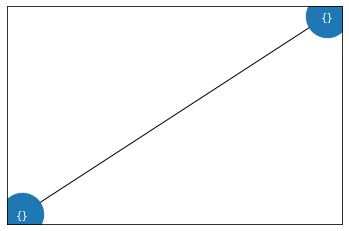

In [7]:
visible_layers = ["sequence"]
hidden_layers = ["hidden"]

v = OneHotLayer(pots, N=N, q=q+1, name="sequence")
h = GaussianLayer(N=200, name="hidden")

E = [(v.name, h.name)]

model_rbm = MRF(layers = {v.name: v,
                    h.name: h}, edges = E, name = "")

for visible in visible_layers:
    edge = model_rbm.get_edge(visible, "hidden")
    edge.gauge = edge.gauge.to(device)
    
optimizer = optim.Adam(model_rbm.parameters(), lr=0.001)

#model.load(f"{DATA}/{DATASET}/weights/seq-reg-200_4320.h5")
#model.ais(n_inter = 2000, verbose = True)

In [ ]:
for epoch in range(40000):
    model_rbm.train_epoch(optimizer, train_loader, visible_layers, hidden_layers, [gamma], epoch,
          savepath=f"{PFAM_DATA}/{DATASET}/weights/seq-reg-200")
    if not epoch % 30:
        model_rbm.val(val_loader, visible_layers, hidden_layers, epoch)

Train Epoch: 0 [100%] || Time: 0 min 33 || Loss: 5.891 || Reg: 2.334 || Acc: 0.690
Train Epoch: 0 [100%] || Time: 0 min 33 || Loss: 5.891 || Reg: 2.334 || Acc: 0.690
Val Epoch: 0 [100%] || Time: 0 min 8 || P(v): -1.308 || P(v,h): -6.039 || Acc: 0.692
Train Epoch: 1 [100%] || Time: 0 min 32 || Loss: 6.307 || Reg: 1.812 || Acc: 0.753


## 5 - Sampling with RBM and SSQA

See `RBMSampling_With_SSQA.ipynb`